# Project 2

# Used Vehicle Price Prediction

#### Angie Paola Chacon Pinzon: 201012536
#### Jahir Stevens Rodriguez Riveros: 201819361
#### Juan Andres Cabal Jaramillo: 200620778
#### David Tavera Sánchez: 201016123

## Introduction

- 1.2 Million listings scraped from TrueCar.com - Price, Mileage, Make, Model dataset from Kaggle: [data](https://www.kaggle.com/jpayne/852k-used-car-listings)
- Each observation represents the price of an used car

In [2]:
%matplotlib inline
import pandas as pd

In [2]:
data = pd.read_csv('datasets/dataTrain_carListings.zip')

In [21]:
data.head()

,Price,Year,Mileage,State,Make,Model
0,21490,2014,31909,MD,Nissan,MuranoAWD
1,21250,2016,25741,KY,Chevrolet,CamaroCoupe
2,20925,2016,24633,SC,Hyundai,Santa
3,14500,2012,84026,OK,Jeep,Grand
4,32488,2013,22816,TN,Jeep,Wrangler


In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 6 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Price    500000 non-null  int64 
 1   Year     500000 non-null  int64 
 2   Mileage  500000 non-null  int64 
 3   State    500000 non-null  object
 4   Make     500000 non-null  object
 5   Model    500000 non-null  object
dtypes: int64(3), object(3)
memory usage: 22.9+ MB


In [23]:
data.Price.describe()

count    500000.000000
mean      21144.186304
std       10753.259704
min        5001.000000
25%       13499.000000
50%       18450.000000
75%       26998.000000
max       79999.000000
Name: Price, dtype: float64

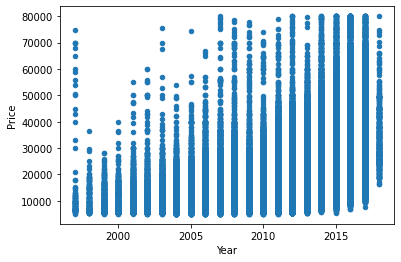

In [24]:
data.plot(kind='scatter', y='Price', x='Year')

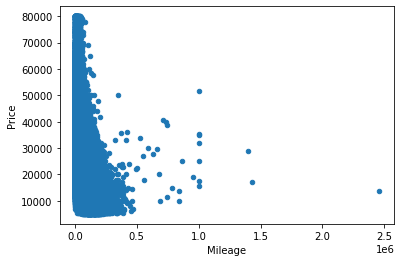

In [25]:
data.plot(kind='scatter', y='Price', x='Mileage')

In [26]:
data.columns

Index(['Price', 'Year', 'Mileage', 'State', 'Make', 'Model'], dtype='object')

# Exercise P2.1 (50%)

Develop a machine learning model that predicts the price of the of car using as an input ['Year', 'Mileage', 'State', 'Make', 'Model']

#### Evaluation:
- 25% - Performance of the models using a manually implemented K-Fold (K=10) cross-validation
- 25% - Notebook explaining the process for selecting the best model. You must specify how the calibration of each of the parameters is done and how these change the performance of the model. It is expected that a clear comparison will be made of all implemented models.. Present the most relevant conslusions about the whole process. 


### Boosting

In [49]:
#%matplotlib inline
#import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingRegressor
from datetime import datetime

In [50]:
def now():
    now = datetime.now()
    current_time = now.strftime("%H:%M:%S")
    print("Current Time =", current_time)

In [28]:
data.groupby(['Make', 'Model']).mean()

Price         Year        Mileage
Make  Model                                            
Acura MDX4WD   11265.890490  2006.501441  124254.394813
      MDXAWD   26546.670020  2012.955734   62650.574447
      RDXAWD   26516.121019  2014.558917   40717.030255
      RDXFWD   26667.457447  2015.007979   33343.989362
      TL4dr    11733.715493  2008.754930  103567.515493
...                     ...          ...            ...
Volvo XC60T6   29072.636646  2014.500000   39991.375776
      XC704dr  12274.263158  2009.063158   95738.505263
      XC90AWD  30444.651111  2013.106667   59612.491111
      XC90FWD  15158.863248  2010.589744   89933.709402
      XC90T6   53176.666667  2017.023810   11986.166667

[536 rows x 3 columns]

In [4]:
states = pd.get_dummies(data['State'])
makes = pd.get_dummies(data['Make'])
models = pd.get_dummies(data['Model'])
df = pd.concat([data[['Price', 'Year', 'Mileage']], states, makes, models], axis = 1)
#df = pd.concat([data[['Price']], makes], axis = 1)
df.shape

(500000, 617)

In [36]:
df.head()

,Price,Year,Mileage,AK,AL,AR,AZ,CA,CO,CT,...,Yaris4dr,YarisBase,YarisLE,Yukon,Yukon2WD,Yukon4WD,Yukon4dr,tC2dr,xB5dr,xD5dr
0,21490,2014,31909,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,21250,2016,25741,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,20925,2016,24633,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,14500,2012,84026,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,32488,2013,22816,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
print(df.columns.to_list())

['Price', 'Year', 'Mileage', ' AK', ' AL', ' AR', ' AZ', ' CA', ' CO', ' CT', ' DC', ' DE', ' FL', ' GA', ' HI', ' IA', ' ID', ' IL', ' IN', ' KS', ' KY', ' LA', ' MA', ' MD', ' ME', ' MI', ' MN', ' MO', ' MS', ' MT', ' NC', ' ND', ' NE', ' NH', ' NJ', ' NM', ' NV', ' NY', ' OH', ' OK', ' OR', ' PA', ' RI', ' SC', ' SD', ' TN', ' TX', ' UT', ' VA', ' VT', ' WA', ' WI', ' WV', ' WY', 'Acura', 'Audi', 'BMW', 'Bentley', 'Buick', 'Cadillac', 'Chevrolet', 'Chrysler', 'Dodge', 'FIAT', 'Ford', 'Freightliner', 'GMC', 'Honda', 'Hyundai', 'INFINITI', 'Jaguar', 'Jeep', 'Kia', 'Land', 'Lexus', 'Lincoln', 'MINI', 'Mazda', 'Mercedes-Benz', 'Mercury', 'Mitsubishi', 'Nissan', 'Pontiac', 'Porsche', 'Ram', 'Scion', 'Subaru', 'Suzuki', 'Tesla', 'Toyota', 'Volkswagen', 'Volvo', '1', '15002WD', '15004WD', '1500Laramie', '1500Tradesman', '200LX', '200Limited', '200S', '200Touring', '25002WD', '25004WD', '3', '300300C', '300300S', '3004dr', '300Base', '300Limited', '300Touring', '35004WD', '350Z2dr', '4Runne

In [32]:
#df = df[['Price','Acura']] #, 'Audi', 'BMW']]
#y = 'Acura'

In [33]:
from sklearn.linear_model import LogisticRegression

In [ ]:
clf = RandomForestClassifier(max_depth=2, random_state=0)
#clf = XGBClassifier(eta=0, gamma=1,colsample_bytree=0.8)
clf.fit(df[['Acura', 'Audi', 'BMW']], df['Price'])
y_hat = clf.predict(df[['Acura', 'Audi', 'BMW']])
y_hat

/Users/jahirrodriguez/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [53]:
# K-Fold (K=10) cross-validation

K = 10
N = data.shape[0]
print(K, N)
acc = []

y = 'Price'

for i in range(0,K):
    X_test = df.loc[i*(N/K):(i+1)*(N/K)-1,]
    y_test = X_test[y]
    X_train = df.loc[set(data.index) - set(X_test.index),]
    y_train = X_train[y]
    X_test = X_test.drop(columns = y)
    X_train = X_train.drop(columns = y)
    now()
    clf = RandomForestRegressor(max_depth=2, random_state=0)
    clf.fit(X_train, y_train)
    y_hat = clf.predict(X_test)
    acc.append(['RF',i, metrics.mean_squared_error(y_hat,y_test)])
    print ('RF iteracion {} mse {}'.format(i, metrics.mean_squared_error(y_hat,y_test)))
    now()
    clf = GradientBoostingRegressor(random_state=0)
    clf.fit(X_train, y_train)
    y_hat = clf.predict(X_test)
    acc.append(['GBR',i, metrics.mean_squared_error(y_hat,y_test)])
    print ('GBR iteracion {} mse {}'.format(i, metrics.mean_squared_error(y_hat,y_test)))

10 500000
Current Time = 06:15:37


/Users/jahirrodriguez/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RF iteracion 0 mse 85823013.50302985
Current Time = 06:16:04
GBR iteracion 0 mse 45326267.721012354
Current Time = 06:23:34


/Users/jahirrodriguez/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RF iteracion 1 mse 84814861.9526495
Current Time = 06:24:00
GBR iteracion 1 mse 44610261.89370184
Current Time = 06:31:26


/Users/jahirrodriguez/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RF iteracion 2 mse 84982767.09874262
Current Time = 06:31:51
GBR iteracion 2 mse 44789318.27111257
Current Time = 06:39:21


/Users/jahirrodriguez/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RF iteracion 3 mse 85647190.1034572
Current Time = 06:39:46
GBR iteracion 3 mse 44569924.15771531
Current Time = 06:47:18


/Users/jahirrodriguez/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RF iteracion 4 mse 85042591.84645845
Current Time = 06:47:43
GBR iteracion 4 mse 44487800.986202054
Current Time = 06:55:18


/Users/jahirrodriguez/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RF iteracion 5 mse 86975118.97593524
Current Time = 06:55:44
GBR iteracion 5 mse 45666476.33959722
Current Time = 07:03:09


/Users/jahirrodriguez/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RF iteracion 6 mse 86183291.8851788
Current Time = 07:03:34
GBR iteracion 6 mse 45305694.17641939
Current Time = 07:11:06


/Users/jahirrodriguez/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RF iteracion 7 mse 85477779.16790934
Current Time = 07:11:31
GBR iteracion 7 mse 44230094.20035584
Current Time = 07:18:58


/Users/jahirrodriguez/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RF iteracion 8 mse 86471182.12914099
Current Time = 07:19:23
GBR iteracion 8 mse 45208360.61340874
Current Time = 07:26:48


/Users/jahirrodriguez/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RF iteracion 9 mse 84518357.36465992
Current Time = 07:27:13
GBR iteracion 9 mse 44559666.402399026


In [ ]:
# list of values to try for max_features
learning_range = np.arange(0.2, 1, 0.2)
n_estimator_range = range(200, 600, 100)
max_depth_range = range(9, 15, 3)

# list to store the average Accuracy for each value of max_features
#accuracy_scores = []

for lr in learning_range:
    for n in n_estimator_range:
        for m in max_depth_range:
            now()
            clf = GradientBoostingRegressor(random_state=0, learning_rate = lr, n_estimators=n,max_depth=m)
            clf.fit(X_train,y_train)
            y_pred=clf.predict(X_test)
            mse=metrics.mean_squared_error(y_pred,y_test)
            print('learning_range {}, n_estimators {}, max_depth {}, mse {}'.format(lr,n, m, mse))
            accuracy_scores.append([lr,n, m, mse])

Current Time = 08:28:57
learning_range 0.1,n_estimators 50, max_depth 1, mse 75230206.1236172
Current Time = 08:30:03
learning_range 0.1,n_estimators 50, max_depth 2, mse 63862130.65263713
Current Time = 08:32:46
learning_range 0.1,n_estimators 50, max_depth 3, mse 55679530.58052121
Current Time = 08:37:33
learning_range 0.1,n_estimators 50, max_depth 4, mse 49330189.46672898
Current Time = 08:44:41
learning_range 0.1,n_estimators 50, max_depth 5, mse 43909866.89225197
Current Time = 08:54:34
learning_range 0.1,n_estimators 50, max_depth 6, mse 40128544.43770137
Current Time = 09:07:20
learning_range 0.1,n_estimators 50, max_depth 7, mse 36699278.88626893
Current Time = 09:22:52
learning_range 0.1,n_estimators 50, max_depth 8, mse 34265379.6500807
Current Time = 09:42:26
learning_range 0.1,n_estimators 50, max_depth 9, mse 32154287.39635317
Current Time = 10:06:37
learning_range 0.1,n_estimators 100, max_depth 1, mse 66317968.88067939
Current Time = 10:08:27
learning_range 0.1,n_estima

In [ ]:
# y = data['Price']
X = data.drop(['Price'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

- Learning rate:  0<𝜂≤1. Fracción de los componentes de un árbol que serán usadas para la estimación del siguiente árbol. Es usado para mejorar la generalización del árbol. Cuando más pequeño es el parámetro es mejor la generalización que hace. Cuándo el valor es 1, significa que se usan todos los componentes del árbol actual para crear el siguiente árbol
- gamma: Ganancia mínima que debe superar una partición para ser incluida en el árbol. Es un número entre [0,inf] y a medida que es más grande el árbol final es más simple.
- colsample_bytree: Fracción de las columnas que serán tomadas para la construcción de cada árbol. tiene un valor entre 0 y 1 siendo 1:"tomar todas las columnas"

In [26]:
print(lr,g,cs)

0.0 3 0.8


In [ ]:
# list of values to try for max_features
learning_range = np.arange(0, 1, 0.1)
gamma_range = range(1, 10)
colsample_range =np.arange(0, 1, 0.1)

# list to store the average Accuracy for each value of max_features
accuracy_scores = []

for lr in learning_range:
    for g in gamma_range:
        for cs in colsample_range:
            clf = XGBClassifier(eta=lr, gamma=g,colsample_bytree=cs)
            clf.fit(X_train,y_train)
            y_pred=clf.predict(X_test)
            acc=metrics.accuracy_score(y_pred,y_test)
            print(acc)
            accuracy_scores.append([lr,g,cs,acc])

In [25]:
# list of values to try for max_features
learning_range = np.arange(0, 1, 0.1)
gamma_range = range(1, 10)
colsample_range =np.arange(0, 1, 0.1)

# list to store the average Accuracy for each value of max_features
accuracy_scores = []

for lr in learning_range:
    for g in gamma_range:
        for cs in colsample_range:
            clf = XGBClassifier(eta=lr, gamma=g,colsample_bytree=cs)
            clf.fit(X_train,y_train)
            y_pred=clf.predict(X_test)
            acc=metrics.accuracy_score(y_pred,y_test)
            print(acc)
            accuracy_scores.append([lr,g,cs,acc])

0.9979
0.9979
0.9979
0.9979
0.9979
0.9979
0.9979
0.9979
0.9979
0.9979
0.9979
0.9979
0.9979
0.9979
0.9979
0.9979
0.9979
0.9979
0.9979
0.9979
0.9979
0.9979
0.9979
0.9979
0.9979
0.9979
0.9979
0.9979


KeyboardInterrupt: 

# Exercise P2.2 (50%)

Create an API of the model.

Example:
![](https://raw.githubusercontent.com/albahnsen/PracticalMachineLearningClass/master/notebooks/images/img015.PNG)

#### Evaluation:
- 40% - API hosted on a cloud service
- 10% - Show screenshots of the model doing the predictions on the local machine


#### On the local machine

In [51]:
from model_deployment.p2model_deployment import predict_price
year=2020
mileage=550
state='AL'
make ='Audi'
model='1'


In [52]:
 predict_price(year,mileage,state,make,model)

1000

In [64]:
from flask import Flask
from flask_restplus import Api, Resource, fields
from sklearn.externals import joblib
from model_deployment.p2model_deployment import predict_price

app = Flask(__name__)

api = Api(
    app, 
    version='1.0', 
    title='Price Prediction API G7',
    description='Angie Paola Chacon Pinzon: 201012536\nJahir Stevens Rodriguez Riveros: 201819361\nJuan Andres Cabal Jaramillo: 200620778\nDavid Tavera Sánchez: 201016123')

ns = api.namespace('predict', 
     description='Price Regressor')
   
parser = api.parser()

parser.add_argument(
    'Year', 
    type=int, 
    required=True, 
    help='Year of the car to be analyzed', 
    location='args')

parser.add_argument(
    'Mileage', 
    type=int, 
    required=True, 
    help='Mileage of the car to be analyzed', 
    location='args')

parser.add_argument(
    'State', 
    type=str, 
    required=True, 
    help='State of the car to be analyzed', 
    location='args')

parser.add_argument(
    'Make', 
    type=str, 
    required=True, 
    help='Maker of the car to be analyzed', 
    location='args')

parser.add_argument(
    'Model', 
    type=str, 
    required=True, 
    help='Model of the car to be analyzed', 
    location='args')


resource_fields = api.model('Resource', {
    'price': fields.String,
})

@ns.route('/')
class PriceApi(Resource):

    @api.doc(parser=parser)
    @api.marshal_with(resource_fields)
    def get(self):
        args = parser.parse_args()
        
        return {
         "price": predict_price(args['Year'],args['Mileage'],args['State'],args['Make'],args['Model'])
        }, 200
    

In [65]:
app.run(debug=True, use_reloader=False, host='0.0.0.0', port=5000)

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


 * Running on http://0.0.0.0:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [29/Jun/2020 10:59:05] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2020 10:59:05] "GET /swagger.json HTTP/1.1" 200 -
127.0.0.1 - - [29/Jun/2020 10:59:26] "GET /predict/?Year=2020&Mileage=1234&State=AL&Make=AUDI&Model=CX HTTP/1.1" 200 -


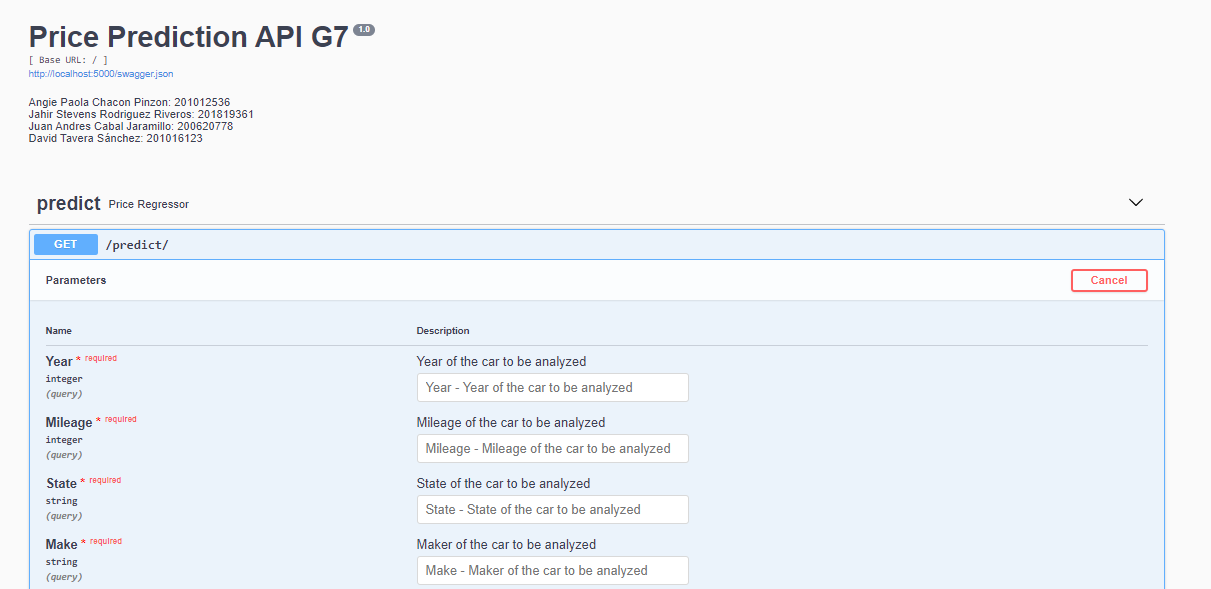